# Challenge - Multi-Class Classification 

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on exploring the potential of supervised models in identifying dark matter based on simulated strong lensing images with different substructure.

### Dataset

The Dataset consists of three classes, strong lensing images with no substructure, spherical substructure, and vortex substructure. The images have been normalized using min-max normalization.

Link to the Dataset: https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view?usp=sharing

### Evaluation Metrics

* ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)   

## Multi-Class Classification using a Supervised Model

### 1. Data Visualization and Preprocessing 

#### 1.1 Install and import all the necessary libraries

In [ ]:
# %cd /content/drive/MyDrive/G Multi Class/
!pip3 install gdown numpy pandas scikit-learn matplotlib tqdm torch torchvision torchaudio wandb

In [ ]:
import numpy as np
import torch

from torch import nn
from torchvision import models
from torch.nn import Conv2d
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, utils

import glob
from pandas.core.common import flatten
import random
import time
from tqdm import tqdm
import sys
import os

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
import matplotlib.pyplot as plt

import wandb
wandb.login()

# Make the notebook reproducible

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 69
seed_everything(seed)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### 1.2 Download the Data

In [ ]:
import gdown

if not os.path.isfile('dataset.zip'):
    url = "https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A"
    output = "dataset.zip"
    gdown.download(url, output, quiet=False)

data_dir = 'dataset'

if not os.path.isdir(data_dir):
    os.system('unzip dataset.zip')

%cd dataset

#### 1.3 Preview the Data

Samples with no substructure: 


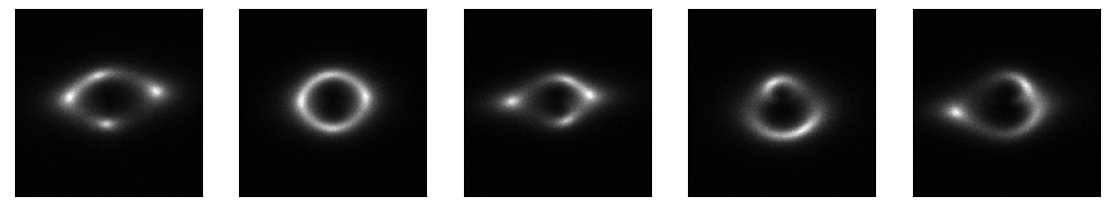

Samples with spherical substructure: 


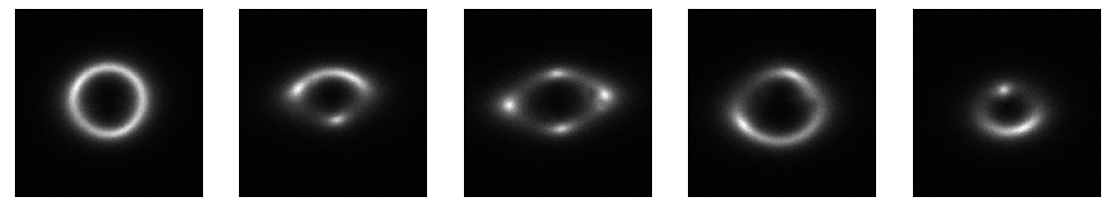

Samples with vortex substructure: 


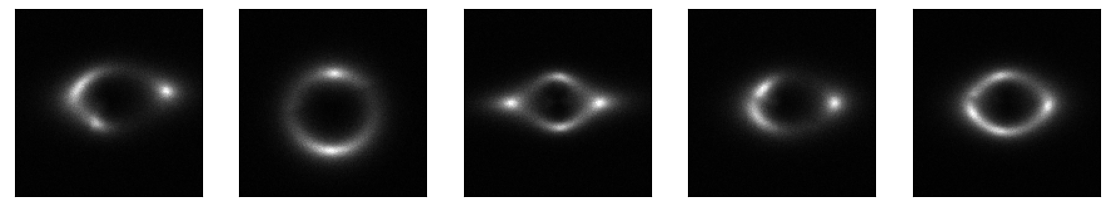

In [ ]:
# Define the input paths
train_path1 = './train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './train/sphere'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './train/vort'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files1[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files2[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files3[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

#### 1.4 Data preparation

In [ ]:
# Create a list of paths to train, validation and test images

train_image_paths = []
classes = []

train_data_path = 'train' 
test_data_path = 'val'

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

train_image_paths, valid_image_paths = train_image_paths[:int(0.9*len(train_image_paths))], train_image_paths[int(0.9*len(train_image_paths)):] 

test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

# Create a mapping between class labels and class numbers

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
# Define a custom dataset to retrieve images and labels

class MyDataset(Dataset):
    def __init__(self, np_file_paths, transform=None):
        self.files = np_file_paths
        self.transform = transform
    
    def __getitem__(self, index):
        image_filepath = self.files[index]
        image = np.load(self.files[index])
        image = torch.from_numpy(image).float()

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.files)

In [ ]:
# Define the trasformations to apply on images

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2))
])

valid_transform = transforms.Compose([
    transforms.Resize((150, 150))
])

test_tranform = transforms.Compose([
    transforms.Resize((150, 150))
])

# Create instances of train, validation and test datasets

train_dataset = MyDataset(train_image_paths, train_transform)
valid_dataset = MyDataset(valid_image_paths, valid_transform)
test_dataset = MyDataset(test_image_paths, test_tranform)

batch_size = 64

# Create data loaders with a batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Set to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Training

#### 2.1 Defining Resnet-18 Model

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, pre_trained):
        super(Resnet18, self).__init__()
        self.backbone = models.resnet18(pretrained=pre_trained)
        self.backbone.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.backbone(x)

#### 2.2 Preparing to train the Resnet-18 Model

In [ ]:
# Define a utility function to check the accuracy of model on a given loader

def check_accuracy(loader, model, device):
    num_samples = 0
    num_correct_pred = 0
    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():
        for (x, y) in loader:
            x = x.to(device)
            y = y.to(device)

            score = model.forward(x)
            val, idx = torch.max(score, dim=1)
            num_correct_pred += (y == idx).sum()
            num_samples += x.shape[0]

            y_pred.extend(list(score.cpu().numpy()))
            y_true.extend((list(y.cpu().numpy())))

        acc = num_correct_pred / num_samples
        y_one_hot = OneHotEncoder().fit_transform(np.array(y_true).reshape(-1, 1)).toarray()
        auc = roc_auc_score(
            y_one_hot.ravel(),
            softmax(np.array(y_pred), axis=1).ravel()
        )

    model.train()
    return acc, auc, y_one_hot, softmax(np.array(y_pred), axis=1)

In [ ]:
# Create a directory to checkpoint the model
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

In [ ]:
# Define the hyperparameters and model
num_epochs = 50
lr = 1e-4
model = Resnet18(True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# # Uncomment to resume training a model
# checkpoint = torch.load("./checkpoint/best_model.pt")
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])

# Define lr scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=4,
    threshold=0.0001,
    min_lr=1e-10,
    verbose=True
)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Start a new wandb run
wandb.init(
    project="deeplense-common-test",
    config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "architecture": "Resnet18",
        "epochs": num_epochs
    }
)

wandb.watch(model, log_freq=100)

wandb: Currently logged in as: yogesh174. Use `wandb login --relogin` to force relogin


[]

#### 2.3 Training/Fine-tuning the Resnet-18 Model

In [ ]:
max_auc = 0.0

for epoch in range(num_epochs):
    losses_per_batch = []
    start_time = time.time()

    # Mini batch training
    p_bar = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), file=sys.stdout)
    for batch_idx, (x_batch, y_batch) in p_bar:
        
        # Move data to gpu if available
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward prop
        scores = model.forward(x_batch)
        loss = criterion(scores, y_batch)
        losses_per_batch.append(loss.item())

        # Backward prop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

    # Compute acc and loss
    cur_acc, auc, _, _ = check_accuracy(valid_loader, model, device)
    mean_loss = sum(losses_per_batch) / len(losses_per_batch)

    # lr scheduler
    scheduler.step(auc)

    # Save best model
    if auc > max_auc:
        checkpoint = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        print(f"epoch: [{epoch + 1}/{num_epochs}], ", end="")

        checkpoint_file = f"./checkpoint/best_model.pt"
        print(f"Saving model ...")
        torch.save(checkpoint, checkpoint_file)
        max_auc = auc

    # Print log
    end_time = time.time()
    print(f"epoch: [{epoch + 1}/{num_epochs}], "
          f"loss: {mean_loss:.8f}, "
          f"val acc: {cur_acc.item():.4f}, "
          f"val auc: {auc:.4f}, "
          f"time used: {(end_time - start_time)/60:.4f}m")

    # Send log
    wandb.log({'accuracy': cur_acc.item(), 'epoch': epoch, 'auc': auc, 'time': (end_time - start_time)/60})

epoch: [1/50], Saving model ...                  
epoch: [1/50], loss: 1.08066677, val acc: 0.4097, val auc: 0.6210, time used: 2.3346m
epoch: [2/50], Saving model ...                  
epoch: [2/50], loss: 0.91274296, val acc: 0.5777, val auc: 0.7845, time used: 1.6901m
epoch: [3/50], Saving model ...                  
epoch: [3/50], loss: 0.73124495, val acc: 0.6803, val auc: 0.8544, time used: 1.7424m
epoch: [4/50], Saving model ...                  
epoch: [4/50], loss: 0.59653842, val acc: 0.7653, val auc: 0.9189, time used: 1.4818m
epoch: [5/50], Saving model ...                  
epoch: [5/50], loss: 0.50822486, val acc: 0.8297, val auc: 0.9471, time used: 1.4523m
epoch: [6/50], Saving model ...                  
epoch: [6/50], loss: 0.45156967, val acc: 0.8243, val auc: 0.9496, time used: 1.4537m
epoch: [7/50], Saving model ...                  
epoch: [7/50], loss: 0.41518440, val acc: 0.8483, val auc: 0.9601, time used: 1.4059m
epoch: [8/50], Saving model ...                 

### 3. Testing

#### 3.1 Testing the Finetuned Resnet-18 Model on testing data

In [ ]:
# Load the best model

model = Resnet18(False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

pretrained_model = "./checkpoint/best_model.pt"
checkpoint = torch.load(pretrained_model)
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### 3.2 Plotting the ROC Curve and computing AUC

acc: 0.9506666660308838, auc: 0.9942414577777778


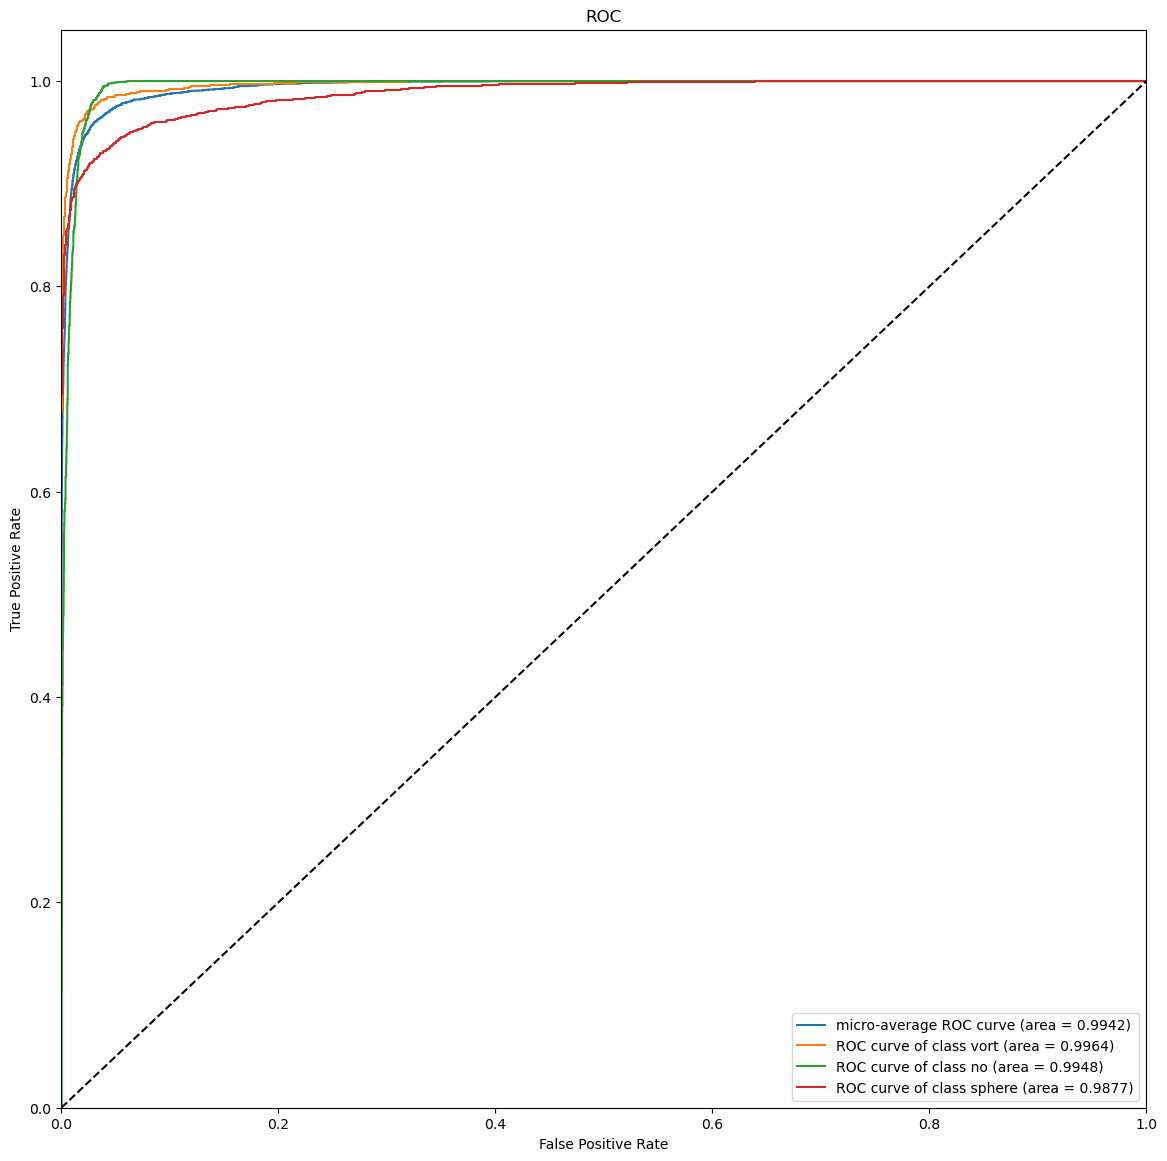

In [ ]:
acc, auc, y_true, y_pred = check_accuracy(test_loader, model, device)
print(f"acc: {acc.item()}, auc: {auc}")

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ idx_to_class[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### 4. Results

The train set is divided in a 90:10 ratio into train and validation datasets. And there is a train set provided.

Validation Accuracy: 94.83% \
Validation AUC: **0.9946**

Test Accuracy: 95.07% \
Test AUC: **0.9942**